In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from gensim.models import Word2Vec
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error
from collections import Counter
import textwrap

In [122]:
articles_df = pd.read_csv('scopus_articles_data.csv')
articles_df.head()

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Link,Abstract,Author Keywords,Index Keywords
0,Martinc M.; Perovšek M.; Lavrač N.; Pollak S.,"Martinc, Matej (57193521100); Perovšek, Matic ...",57193521100; 55916209600; 7004388979; 55543643800,Textflows: an open science NLP evaluation appr...,2024,Language Resources and Evaluation,https://www.scopus.com/inward/record.uri?eid=2...,Web-based platforms offer suitable experimenta...,NLP evaluation; Online platform; Open source; ...,NaN
1,Rodrigues F.; Lima R.; Domingues W.; Fidalgo R...,"Rodrigues, Francisco (57215870757); Lima, Rina...",57215870757; 36175808200; 59872176300; 8659107...,DeepNLPF: A framework for integrating third-pa...,2020,LREC 2020 - 12th International Conference on L...,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) of textual d...,Framework; Natural Language Processing; NLP to...,Pipeline processing systems; Pipelines; Semant...
2,Chen H.; Liu F.; Chen J.; Ji K.; Cui Y.; Ge W....,"Chen, Huilong (57422682000); Liu, Fang (598642...",57422682000; 59864249800; 56018340500; 5742237...,"Identification, molecular evolution, codon bia...",2024,Frontiers in Genetics,https://www.scopus.com/inward/record.uri?eid=2...,The NODULE-INCEPTION-like protein (NLP) family...,codon bias; foxtail millet; molecular evolutio...,NLP transcription factor; transcription factor...
3,Shankar V.; Parsana S.,"Shankar, Venkatesh (7102439832); Parsana, Sohi...",7102439832; 57200450074,An overview and empirical comparison of natura...,2022,Journal of the Academy of Marketing Science,https://www.scopus.com/inward/record.uri?eid=2...,With artificial intelligence permeating conver...,Artificial intelligence; Autoencoder; Machine ...,NaN
4,Wang Y.-S.,"Wang, Yi-Siang (57216993409)",57216993409,The platform providing NLP system deep compara...,2018,Proceedings of the 30th Conference on Computat...,https://www.scopus.com/inward/record.uri?eid=2...,"This platform includes two main concepts. One,...",Compare NLP systems; Compare NLP tools; Evalua...,Computational linguistics; Speech processing; ...


In [123]:
abstracts = articles_df['Abstract'].dropna().tolist()

In [124]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 3.3 MB/s eta 0:00:04
     ----- ---------------------------------- 1.8/12.8 MB 3.7 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 3.9 MB/s eta 0:00:03
     ---------- ----------------------------- 3.4/12.8 MB 3.7 MB/s eta 0:00:03
     ------------ --------------------------- 3.9/12.8 MB 3.6 MB/s eta 0:00:03
     -------------- ------------------------- 4.7/12.8 MB 3.6 MB/s eta 0:00:03
     ----------------- ---------------------- 5.5/12.8 MB 3.5 MB/s eta 0:00:03
     ------------------ --------------------- 6.0/12.8 MB 3.5 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 3.5 MB/s eta 0:00:02
     ----------------------- ---------------- 7.6/12.8 MB 3.5 MB/s eta 0:00:02
     -------------------------- ------------- 8.4/12.8 MB 3.5 MB/s

2025-07-04 18:16:11.871996: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



In [125]:
def preprocess_texts(texts):
    def process_text(text):
        return ' '.join([
            token.lemma_.lower()
            for token in text
            if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
        ])

    return [process_text(text) for text in nlp.pipe(texts, batch_size=50, n_process=4)]

processed_abstracts = preprocess_texts(abstracts)
print(abstracts[0:5])
print(processed_abstracts[0:5])


KeyboardInterrupt: 

Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\multiprocessing\queues.py", line 247, in _feed
    send_bytes(obj)
  File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\multiprocessing\connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\multiprocessing\connection.py", line 295, in _send_bytes
    nwritten, err = ov.GetOverlappedResult(True)
BrokenPipeError: [WinError 109] The pipe has been ended
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\multiprocessing\queues.py", line 247, in _feed
    send_bytes(obj)
  File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\multiprocessing\connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\multiprocessing\connection.py", li

In [ ]:
def create_bar_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(14, 8)) 

    wrapped_labels = [ '\n'.join(textwrap.wrap(str(label), 15)) for label in data.index ]

    ax = data.plot(kind='bar', color='cornflowerblue', edgecolor='black')

    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    plt.xticks(ticks=range(len(data)), labels=wrapped_labels, rotation=90, ha='center', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for p in ax.patches:
        height = p.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_bins_chart(data, title, xlabel, ylabel, bins_number=30):
    plt.hist(data, bins=bins_number, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.show()
    
def create_wordcloud(scored_tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(scored_tokens)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

[('nlp', 17013), ('language', 7051), ('data', 5161), ('processing', 4490), ('natural', 4333), ('models', 3992), ('based', 3642), ('model', 3316), ('text', 3193), ('research', 3123), ('learning', 3122), ('analysis', 2865), ('study', 2489), ('paper', 2314), ('results', 2297), ('information', 2262), ('methods', 2258), ('techniques', 2073), ('tasks', 2000), ('system', 1855), ('use', 1795), ('performance', 1771), ('machine', 1618), ('approach', 1615), ('accuracy', 1537), ('clinical', 1467), ('systems', 1421), ('applications', 1403), ('different', 1327), ('work', 1268), ('time', 1193), ('human', 1187), ('classification', 1161), ('task', 1136), ('process', 1124), ('method', 1121), ('sentiment', 1117), ('deep', 1106), ('ieee', 1106), ('potential', 1079), ('proposed', 1066), ('large', 1052), ('development', 1040), ('health', 1017), ('knowledge', 1001), ('training', 993), ('tools', 993), ('new', 988), ('computational', 985), ('social', 971), ('review', 967), ('approaches', 954), ('ai', 949), ('c

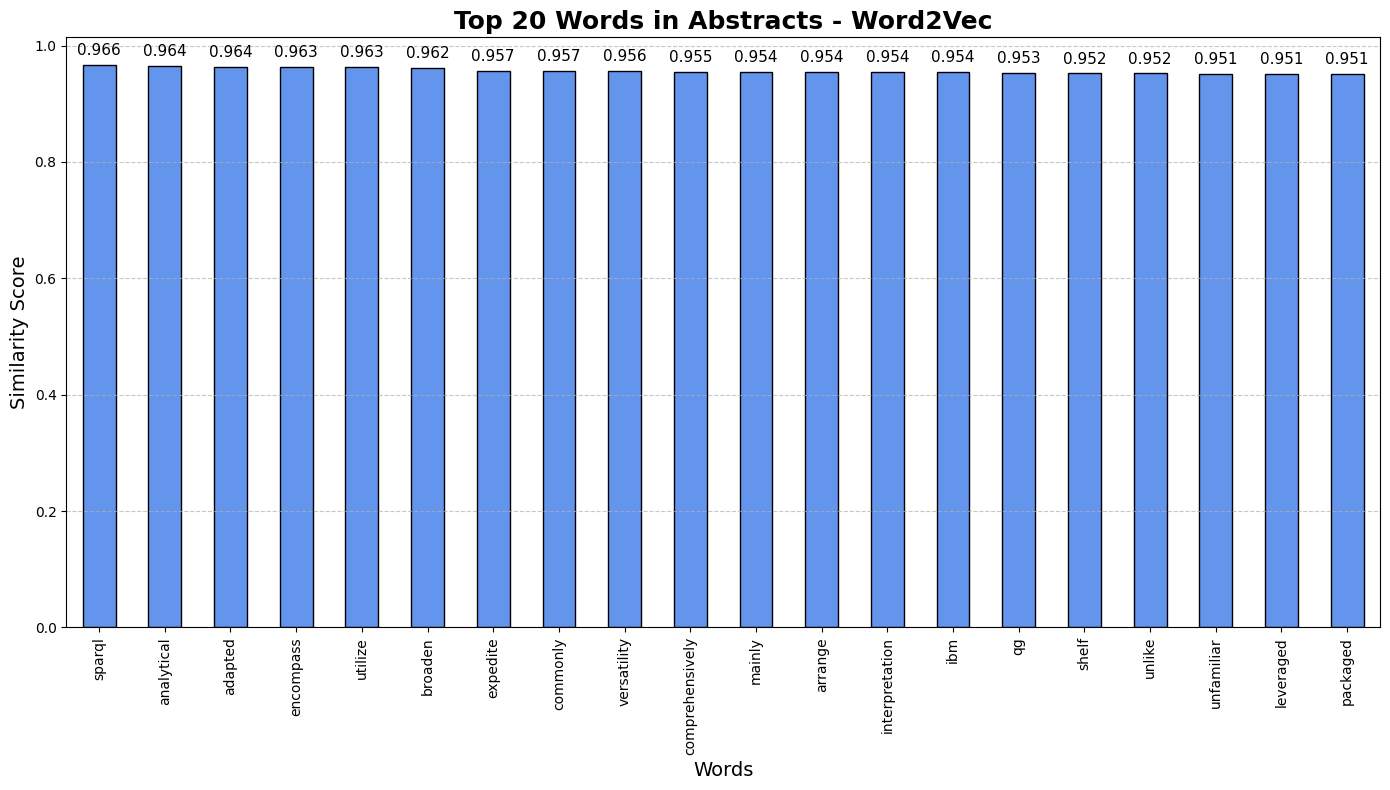

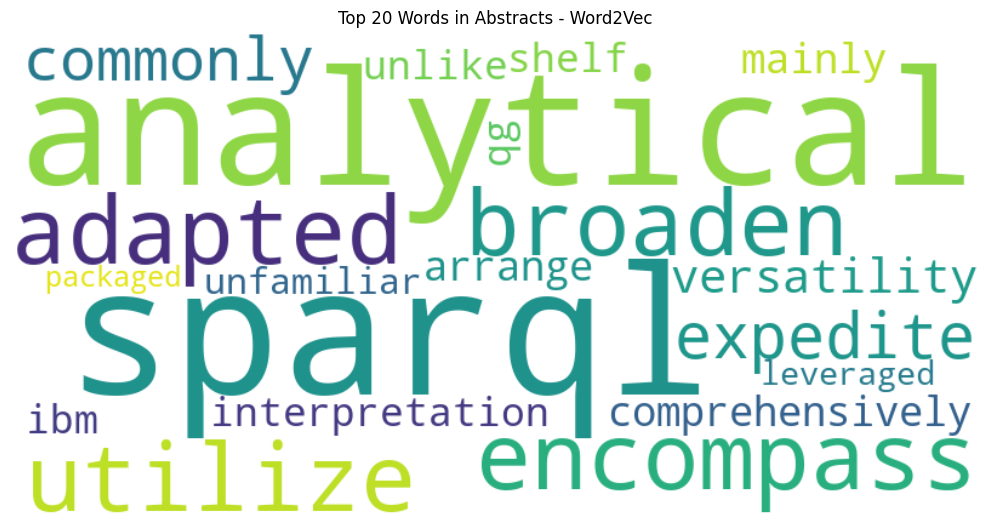

In [ ]:
abstracts_splitted_tokens = [text.split() for text in processed_abstracts]
model = Word2Vec(sentences=abstracts_splitted_tokens, vector_size=300, window=7, min_count=3, workers=4)

all_tokens = [token for tokens in abstracts_splitted_tokens for token in tokens if token in model.wv]
mean_vector = sum(model.wv[token] for token in all_tokens) / len(all_tokens)
similar_words = model.wv.similar_by_vector(mean_vector, topn=20)
top_100_words = model.wv.index_to_key[:100]
top_100_words_with_counts = [(word, model.wv.get_vecattr(word, "count")) for word in top_100_words]
print(top_100_words_with_counts)
words, scores = zip(*similar_words)

create_bar_chart(pd.Series(scores, index=words), "Top 20 Words in Abstracts - Word2Vec", "Words", "Similarity Score")
create_wordcloud(dict(similar_words), "Top 20 Words in Abstracts - Word2Vec")


              word     score
14113          nlp  0.051910
11558     language  0.029467
5004          data  0.028132
13276       models  0.025765
11693     learning  0.021467
13266        model  0.021190
21111         text  0.021069
16534   processing  0.020112
1938         based  0.019891
17920     research  0.019756
13802      natural  0.019675
902       analysis  0.018665
20909        tasks  0.016514
10376  information  0.015993
15143        paper  0.015928
20967   techniques  0.015330
20269        study  0.015114
12917      methods  0.014801
20781       system  0.014445
18043      results  0.013320


<Figure size 1200x800 with 0 Axes>

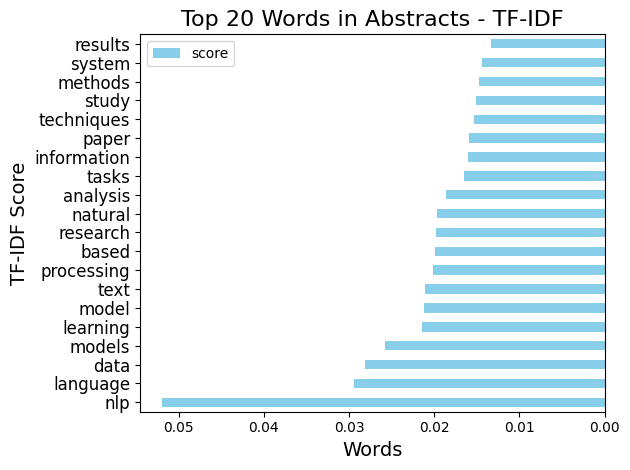

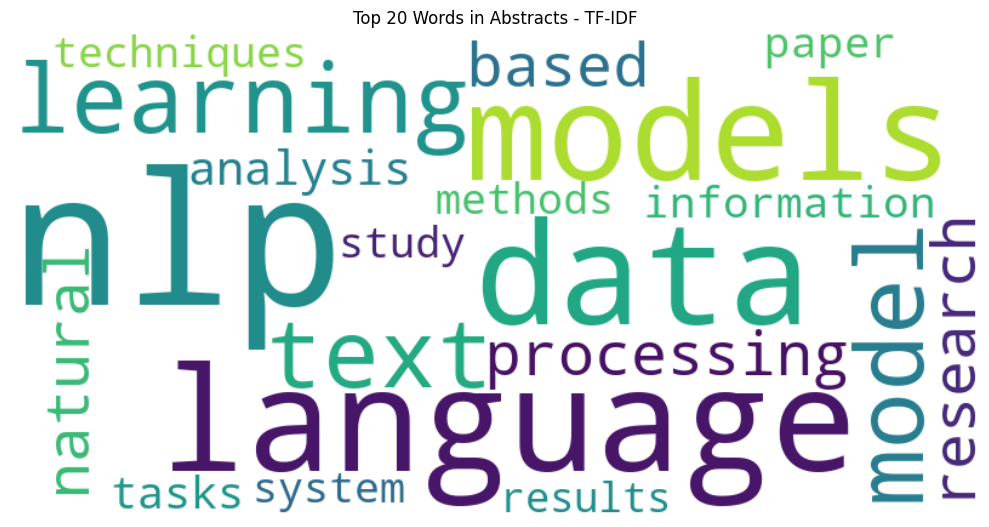

In [ ]:

def extract_top_tfidf_words(texts, top_n=20):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    tfidf_scores = X.mean(axis=0).A1 
    words = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame({'word': words, 'score': tfidf_scores})
    tfidf_df = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return tfidf_df

top_words_df = extract_top_tfidf_words(processed_abstracts)
print(top_words_df)

create_bar_chart(top_words_df.set_index('word'), "Top 20 Words in Abstracts - TF-IDF", "Words", "TF-IDF Score")
create_wordcloud(dict(zip(top_words_df['word'], top_words_df['score'])), "Top 20 Words in Abstracts - TF-IDF")


370/370 [==============================] - 0s 526us/step
Top 20 words with highest reconstruction error:
state: 0.017659
artificial: 0.007939
art: 0.006504
making: 0.004505
health: 0.004357
decision: 0.004143
neural: 0.003931
years: 0.003271
intelligence: 0.003213
recent: 0.003173
nlp: 0.003024
data: 0.003022
media: 0.002989
mental: 0.002928
results: 0.002773
text: 0.002691
information: 0.002678
large: 0.002670
trained: 0.002630
linguistics: 0.002446


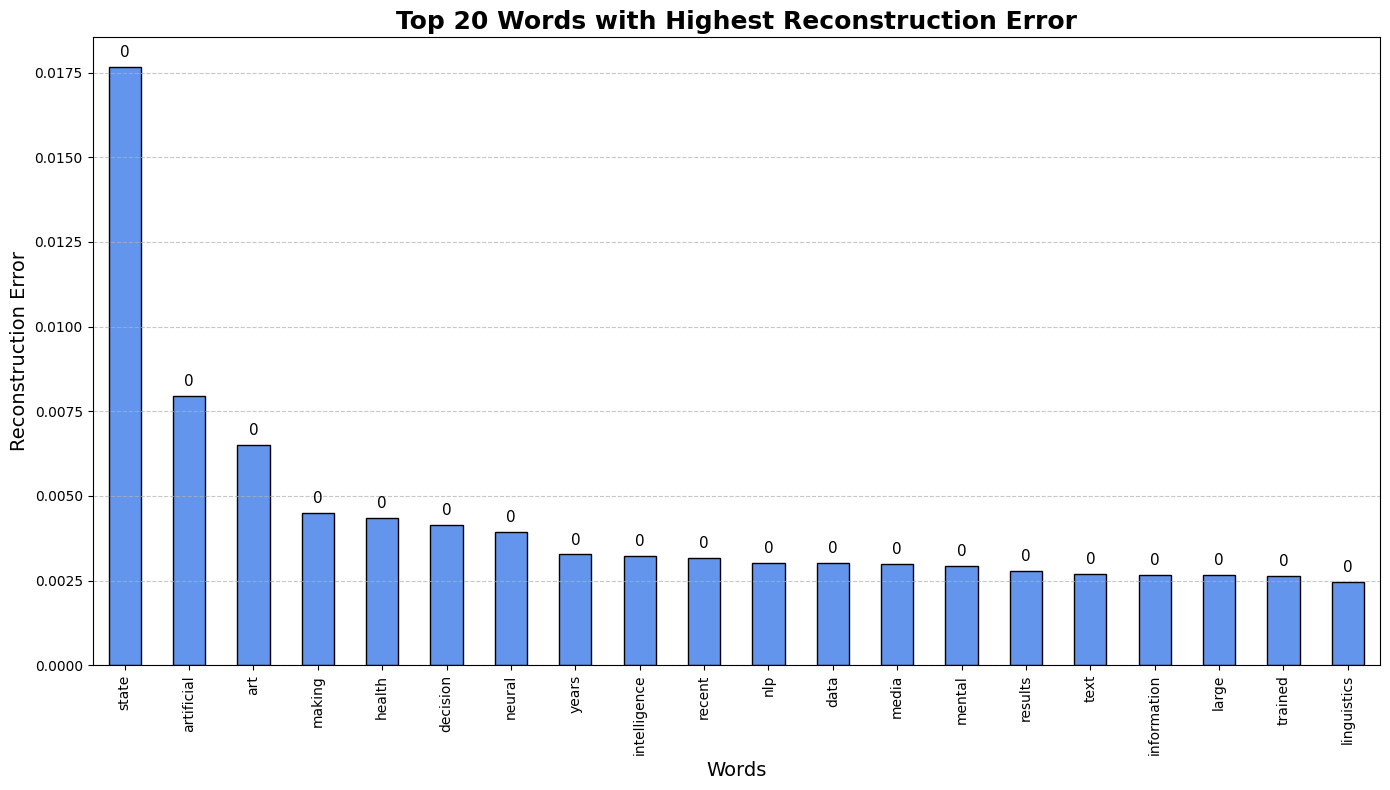

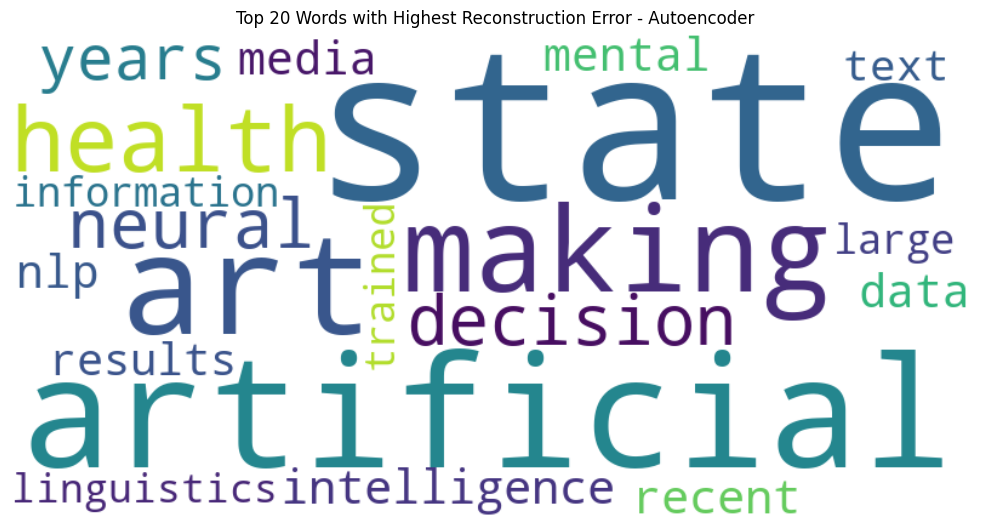

In [ ]:

words = model.wv.index_to_key
vectors = np.array([model.wv[word] for word in words])

# Input size is vector_size (e.g., 100 or 300)
input_dim = vectors.shape[1]

# the autoencoder gets the Word2Vec vectors as input
input_layer = Input(shape=(input_dim,))
# the encoder compresses the input vectors to a lower dimension
encoded = Dense(128, activation='relu')(input_layer)
# the decoder reconstructs the original vectors from the compressed representation
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(vectors, vectors, epochs=50, batch_size=256, shuffle=True, verbose=0)


predicted_vectors = autoencoder.predict(vectors)
errors = [mean_squared_error(vectors[i], predicted_vectors[i]) for i in range(len(vectors))]
word_errors = list(zip(words, errors))

word_errors_sorted = sorted(word_errors, key=lambda x: x[1], reverse=True)

print(f"Top {20} words with highest reconstruction error:")
for word, error in word_errors_sorted[:20]:
    print(f"{word}: {error:.6f}")
create_bar_chart(pd.Series([error for _, error in word_errors_sorted[:20]], index=[word for word, _ in word_errors_sorted[:20]]),
                  "Top 20 Words with Highest Reconstruction Error", "Words", "Reconstruction Error")
create_wordcloud(dict(word_errors_sorted[:20]), "Top 20 Words with Highest Reconstruction Error - Autoencoder")

# NER

In [ ]:
nlp.enable_pipe("ner")
def extract_entities(texts):
    entities = []
    for doc in nlp.pipe(texts, batch_size=50, n_process=4):
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))
    return entities
entities = extract_entities(abstracts)

[('NLP', 'ORG'), ('NLP', 'ORG'), ('NLP', 'ORG'), ('TextFlows', 'ORG'), ('NLP', 'ORG'), ('TextFlows', 'ORG'), ('NLP', 'ORG'), ('seven', 'CARDINAL'), ('NLP', 'ORG'), ('six', 'CARDINAL')]


In [ ]:
entity_counter = Counter(entities)
print("Top 20 entities seen with their types:")
for (ent, label), count in entity_counter.most_common(20):
    print(f"{ent} ({label}): {count}")

Top 20 entities with their types:
NLP (ORG): 15824
two (CARDINAL): 852
AI (ORG): 653
Natural Language Processing (ORG): 626
2024 (DATE): 605
BERT (ORG): 584
three (CARDINAL): 550
first (ORDINAL): 540
2022 (DATE): 502
English (LANGUAGE): 435
2021 (DATE): 425
2023 (DATE): 399
2025 (DATE): 394
ML (ORG): 364
2 (CARDINAL): 331
one (CARDINAL): 307
2024 (CARDINAL): 298
1 (CARDINAL): 297
2023 (CARDINAL): 285
four (CARDINAL): 264


# EDA

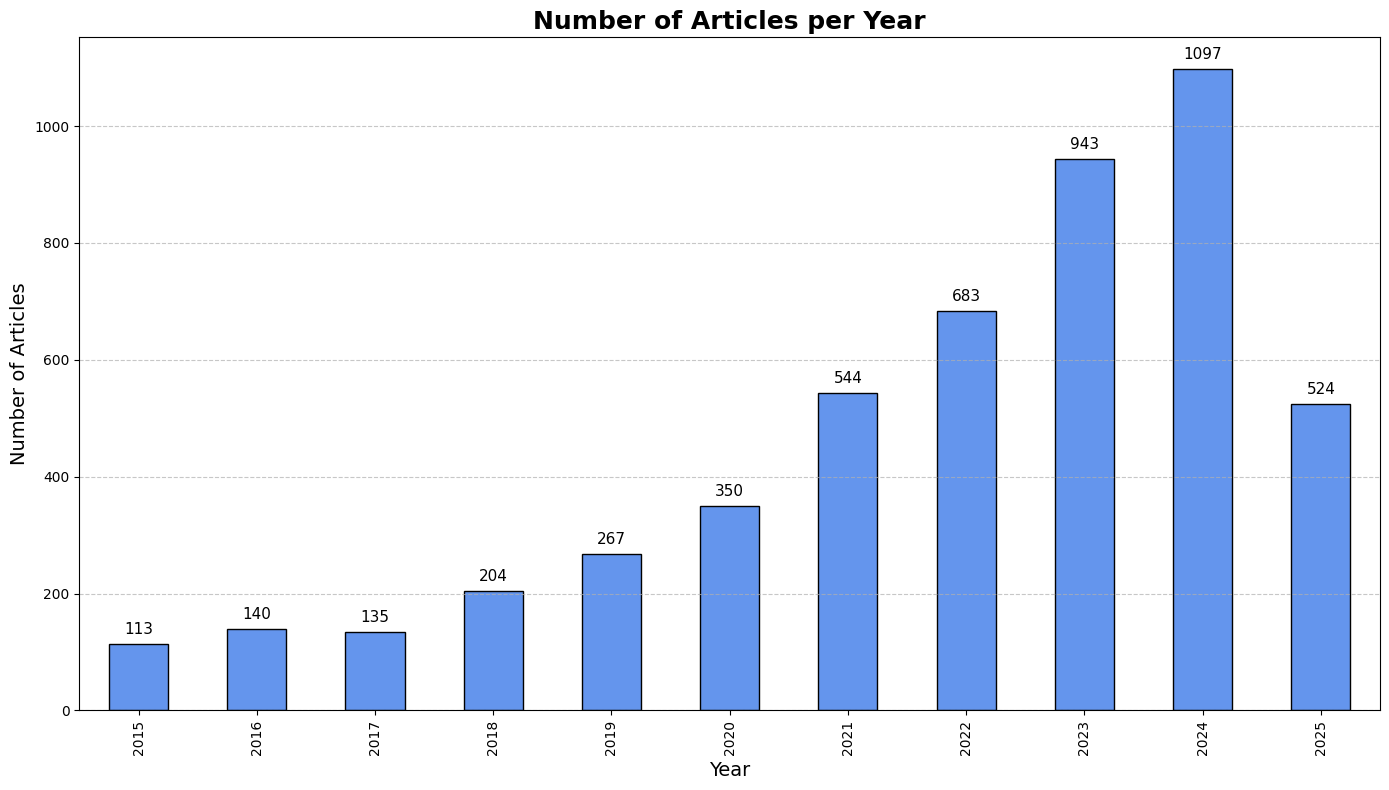

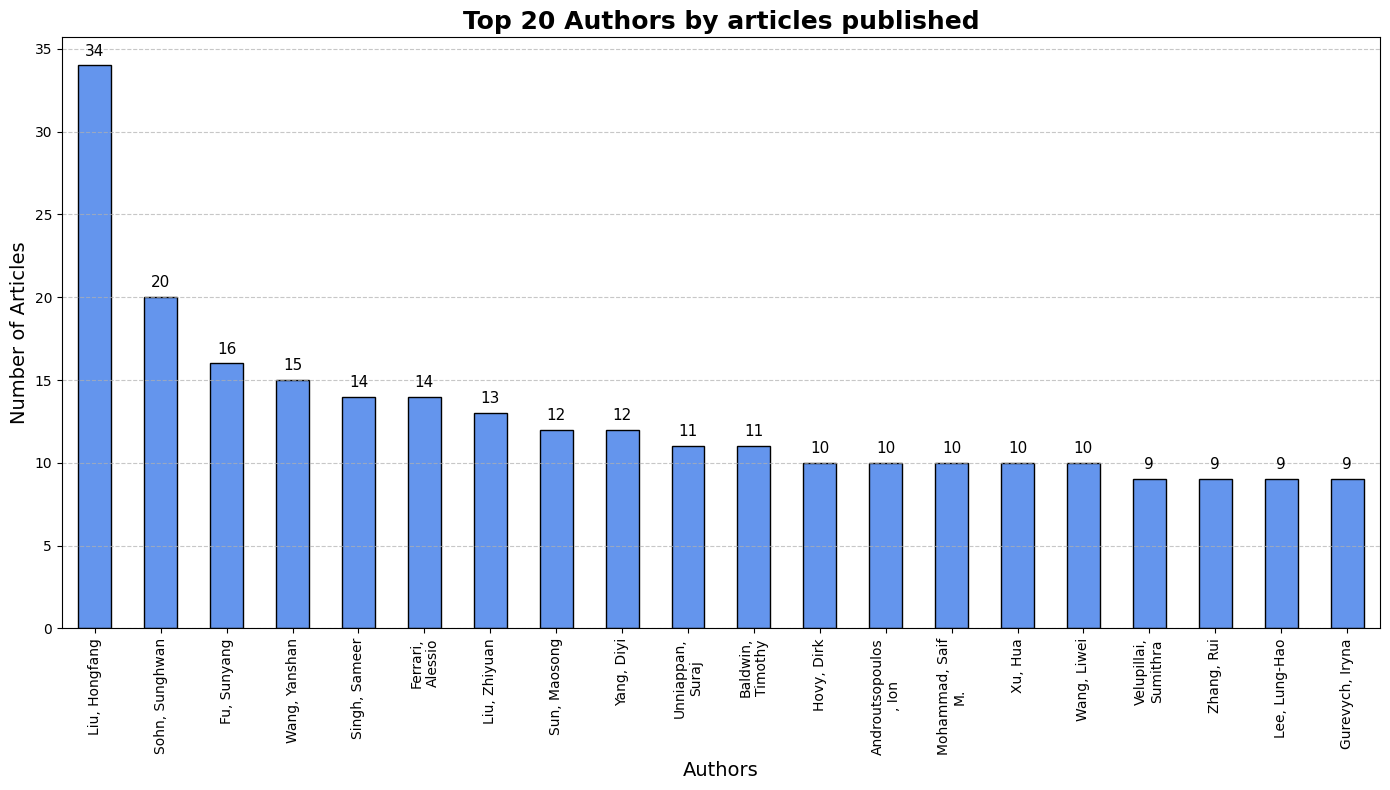

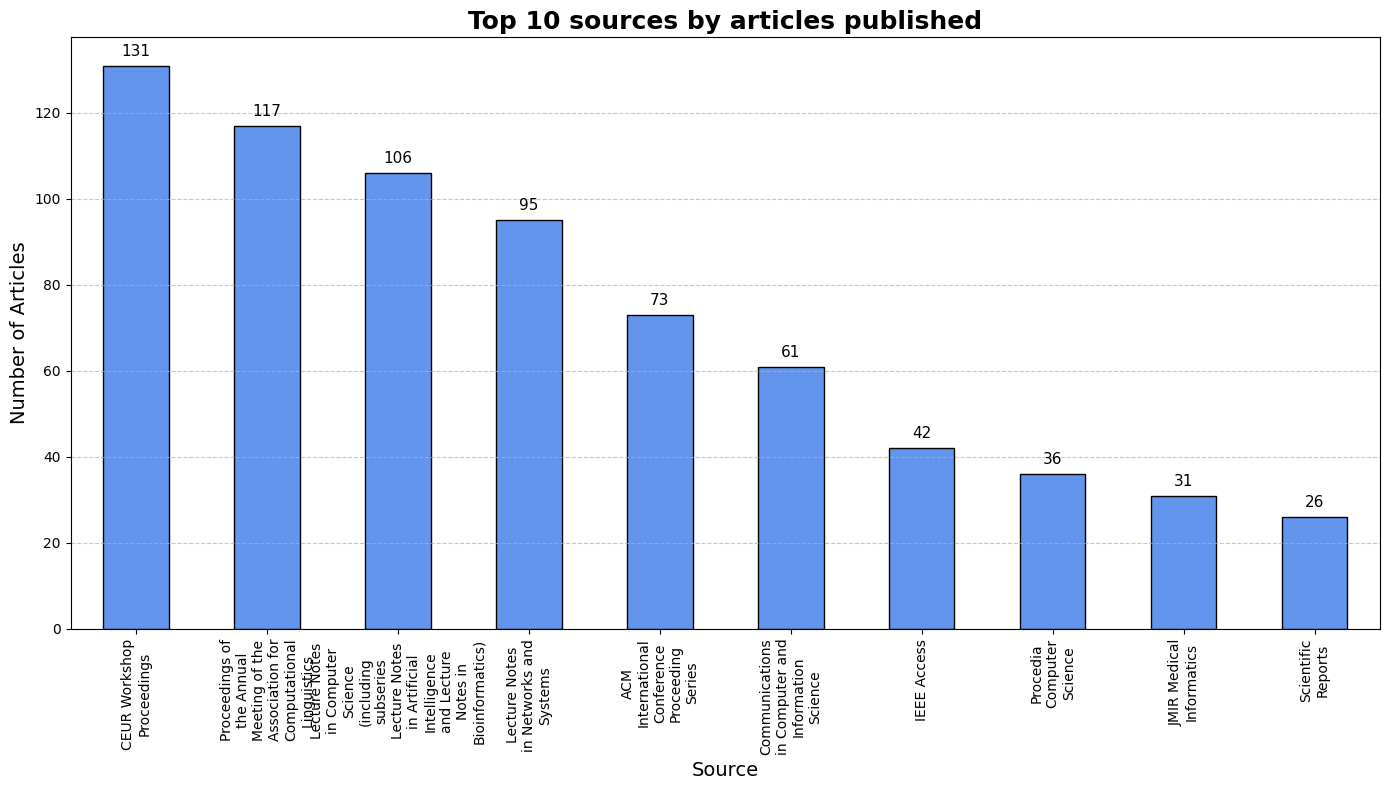

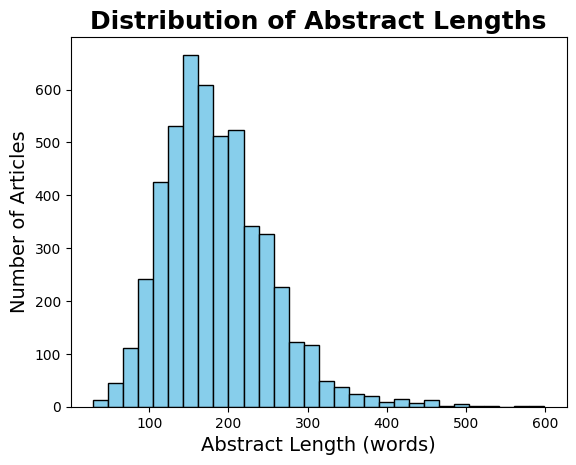

In [ ]:
# count how many articles in each year
articles_per_year = articles_df['Year'].value_counts().sort_index()
create_bar_chart(articles_per_year, "Number of Articles per Year", "Year", "Number of Articles")
# Top authors (split by semicolon if multiple authors)
all_authors = articles_df['Author full names'].dropna().str.split(';').explode().str.strip()
# remove (ID) from author names
all_authors = all_authors.str.replace(r'\s*\(.*?\)', '', regex=True)
top_authors = all_authors.value_counts().head(20)
create_bar_chart(top_authors, "Top 20 Authors by articles published", "Authors", "Number of Articles")

top_sources = articles_df['Source title'].value_counts().head(10)
create_bar_chart(top_sources, "Top 10 sources by articles published", "Source", "Number of Articles")

abstracts_lengths = articles_df['Abstract'].dropna().apply(lambda x: len(x.split()))
create_bins_chart(abstracts_lengths, "Distribution of Abstract Lengths", "Abstract Length (words)", "Number of Articles")

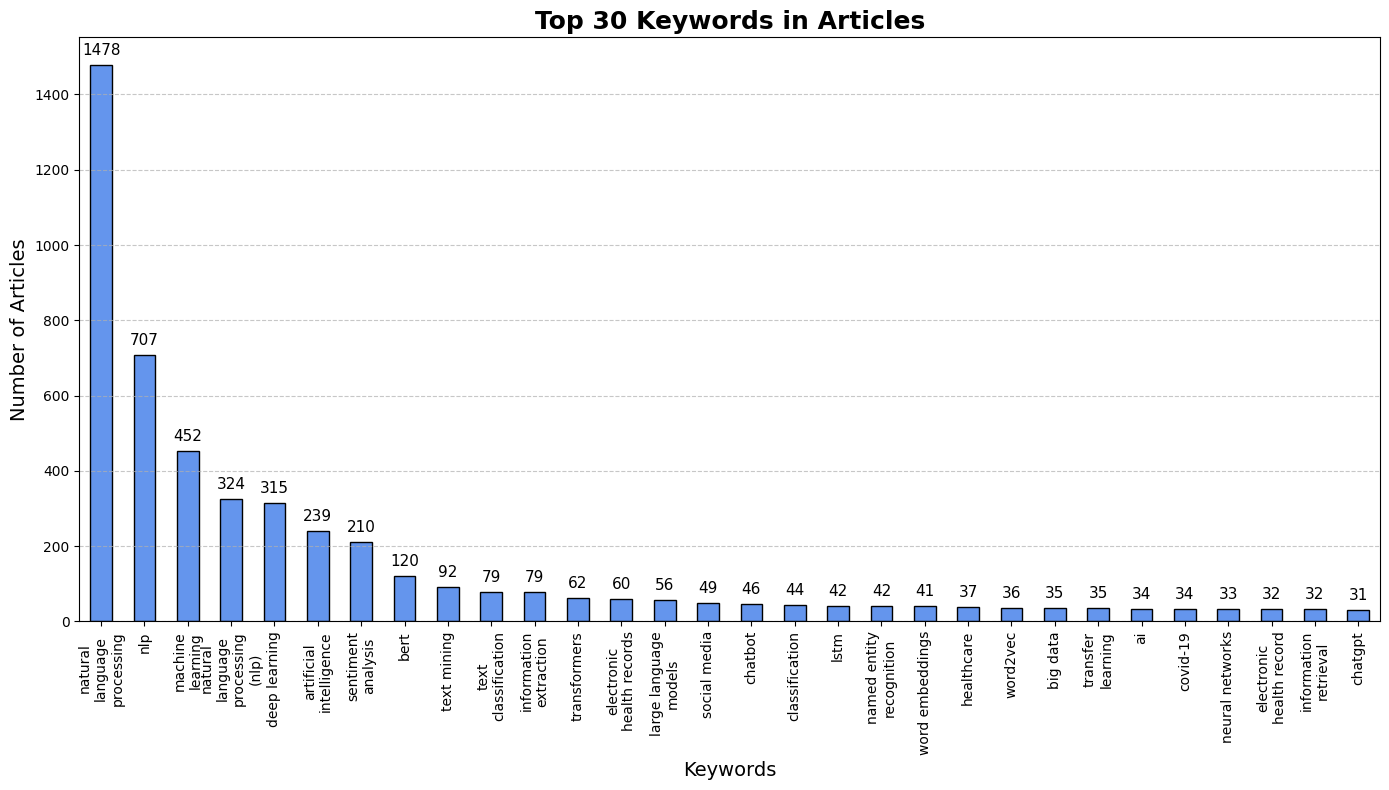

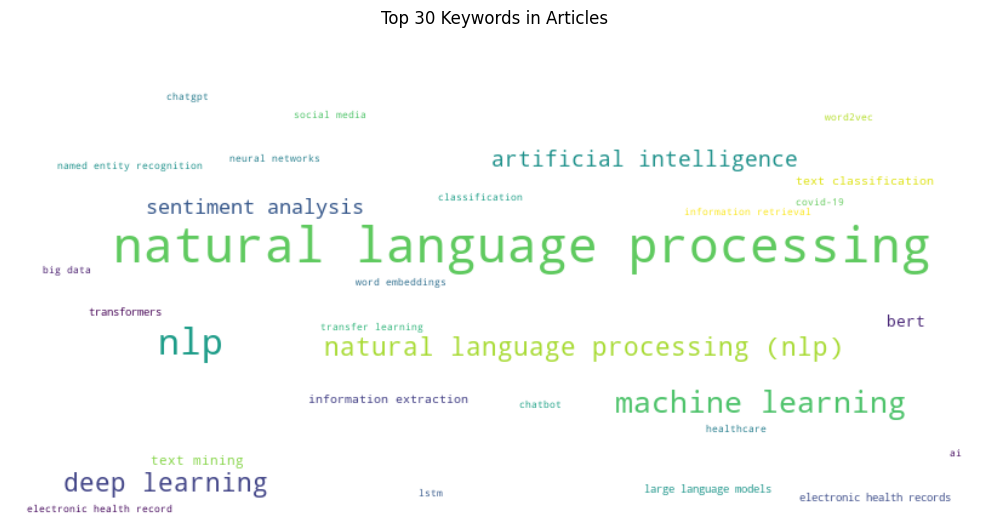

In [148]:
all_keywords = articles_df['Author Keywords'].dropna().str.split(';').explode().str.strip().str.lower()
keyword_counts = all_keywords.value_counts().head(30)
create_bar_chart(keyword_counts, "Top 30 Keywords in Articles", "Keywords", "Number of Articles")
create_wordcloud(dict(keyword_counts), "Top 30 Keywords in Articles")